# Identifying Preferred Courses by Students Using K-Means Clustering

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load

# For better plot appearance
%matplotlib inline

## 1. Load data

In [2]:
# load data 
data_mahasiswa = pd.read_csv('MHS.csv')  
data_krs = pd.read_csv('KRS.csv')  
 
data_mahasiswa.head()

,npm_mahasiswa,nama_mahasiswa,prodi_mahasiswa,angkatan_mahasiswa,ipk_mahasiswa,status_mahasiswa,pembimbing_tugas_akhir
0,1931173,Celine Te,Sistem Informasi,2019,3.87,Lulus,5120028.0
1,1931001,Rido Renando,Sistem Informasi,2019,3.72,Lulus,1170002.0
2,1931009,Richie Marlon,Sistem Informasi,2019,3.90,Lulus,5120028.0
3,1931083,Elvin Whang,Sistem Informasi,2019,3.68,Lulus,6200076.0
4,2031001,Robin Sunjaya,Sistem Informasi,2020,3.88,Aktif,9180074.0


In [3]:
data_krs.head()

,npm_mahasiswa,jenis_semester,tahun_semester,kode_kelas,kode_matkul,nama_matkul,sks_matakuliah,total_hadir,total_pertemuan,total_terlaksana,total_tidak_hadir,kode_nilai,kategori_matakuliah
0,1931001,ganjil,2019,1BUMA,SI00194,Agama,2,0,0,0,0,A,Agama
1,1931001,ganjil,2019,1SIMA,SI00153,Arsitektur dan Organisasi Komputer,3,0,0,0,0,A,Computer Hardware
2,1931001,ganjil,2019,1VUMD,SI00192,Bahasa Inggris I,2,0,0,0,0,A,Bahasa
3,1931001,ganjil,2019,1SIMA,SIL0085,Lab. Teknik Pemograman,1,0,0,0,0,A,Basic Programming
4,1931001,ganjil,2019,1SIMA,SI00151,Pengantar Sistem Informasi,3,0,0,0,0,B,Manajemen


In [4]:
# Merge data_krs and data_mahasiswa using 'npm_mahasiswa' as the key  
merged_data = pd.merge(data_krs, data_mahasiswa, on='npm_mahasiswa')  

# Drop null data
merged_data.dropna(inplace=True)

# Apply conditions directly to merged_data
merged_data = merged_data[
    (merged_data['total_terlaksana'] != 0) &  # Condition 1: total_terlaksana is not 0
    ((merged_data['total_hadir'] != 0) | (merged_data['kode_nilai'].isna())) &  # Condition 2: total_hadir is not 0 OR kode_nilai is NaN
    (merged_data['total_pertemuan'] != 0)  # Condition 3: total_pertemuan is not 0
]

# Optionally, drop any remaining NaN values if needed
merged_data.dropna(inplace=True)

# Display the filtered merged_data
merged_data.head()


,npm_mahasiswa,jenis_semester,tahun_semester,kode_kelas,kode_matkul,nama_matkul,sks_matakuliah,total_hadir,total_pertemuan,total_terlaksana,total_tidak_hadir,kode_nilai,kategori_matakuliah,nama_mahasiswa,prodi_mahasiswa,angkatan_mahasiswa,ipk_mahasiswa,status_mahasiswa,pembimbing_tugas_akhir
6033,1931001,genap,2020,2BAMA,SI00260,Bahasa Mandarin,3,14,14,14,0,A,Bahasa,Rido Renando,Sistem Informasi,2019,3.72,Lulus,1170002.0
6034,1931001,genap,2020,4DKVA,SI00268,Statistik Untuk Riset,3,14,14,14,0,B,Tugas AKhir,Rido Renando,Sistem Informasi,2019,3.72,Lulus,1170002.0
6035,1931001,genap,2020,4DKVA,SI00163,Teknologi Game,3,14,14,14,0,A,Game Making,Rido Renando,Sistem Informasi,2019,3.72,Lulus,1170002.0
6036,1931001,genap,2020,4DKVA,SI00233,Desain Kreatif,3,14,14,14,0,A,Design,Rido Renando,Sistem Informasi,2019,3.72,Lulus,1170002.0
6037,1931001,genap,2020,4DKVA,SI00208,Teknik Pemasaran Digital,3,14,14,14,0,B,Marketing,Rido Renando,Sistem Informasi,2019,3.72,Lulus,1170002.0


## 2. Choose and Prepare Features

In [5]:
# mapping `nilai`
nilai_mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'E': 0}  
merged_data['kode_nilai_numerik'] = merged_data['kode_nilai'].map(nilai_mapping)  


# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'kategori_matakuliah' column
merged_data['kategori_matakuliah_encoded'] = label_encoder.fit_transform(merged_data['kategori_matakuliah'])

# choose relevant features for clustering  

# todo: add more features to clustering  
# Now, use the encoded 'kategori_matakuliah' for clustering
features = merged_data[['total_hadir', 'sks_matakuliah', 'kode_nilai_numerik', 'kategori_matakuliah_encoded']]

features.head()

,total_hadir,sks_matakuliah,kode_nilai_numerik,kategori_matakuliah_encoded
6033,14,3,4,2
6034,14,3,3,25
6035,14,3,4,8
6036,14,3,4,6
6037,14,3,3,18


## 4. Data Normalization

In [6]:
# normalize data using StandardScaler  
scaler = StandardScaler()  
features_scaled = scaler.fit_transform(features)  

pd.DataFrame(features_scaled, columns=features.columns)

,total_hadir,sks_matakuliah,kode_nilai_numerik,kategori_matakuliah_encoded
0,0.556283,0.504802,0.454178,-1.180184
1,0.556283,0.504802,-0.816870,1.626915
2,0.556283,0.504802,0.454178,-0.447898
3,0.556283,0.504802,0.454178,-0.691993
4,0.556283,0.504802,-0.816870,0.772580
...,...,...,...,...
21113,0.556283,0.504802,-0.816870,1.626915
21114,-2.308082,-2.568691,-3.358964,-0.447898
21115,-2.717277,-2.568691,-0.816870,1.016676
21116,-0.671302,0.504802,-2.087917,-0.447898


In [7]:
# calculate Silhouette Score for each k values  
silhouette_scores = []  

 # test using 2 - 9 
k_values = range(2, 10)

for k in k_values:  
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)  
    kmeans.fit(features_scaled)  
    score = silhouette_score(features_scaled, kmeans.labels_)  
    silhouette_scores.append(score)

In [8]:
for score in silhouette_scores:
    print(f'Silhouette Score for {silhouette_scores.index(score)+2} clusters: {score}')

Silhouette Score for 2 clusters: 0.52725426075346
Silhouette Score for 3 clusters: 0.3897470464678565
Silhouette Score for 4 clusters: 0.42766476326327707
Silhouette Score for 5 clusters: 0.43607568301734084
Silhouette Score for 6 clusters: 0.4424966628878042
Silhouette Score for 7 clusters: 0.459082744642308
Silhouette Score for 8 clusters: 0.4821212900142535
Silhouette Score for 9 clusters: 0.4770727576804068


## 6. Visualize Silhouette Scores

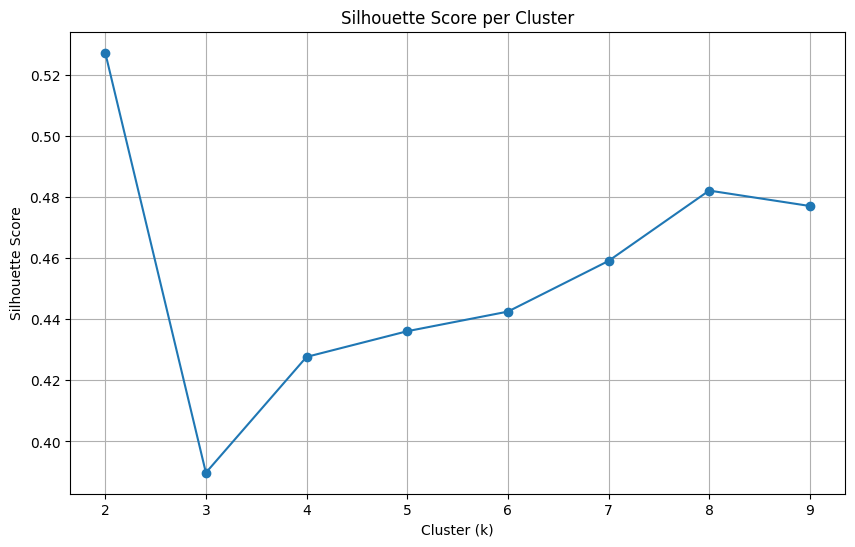

In [9]:
# Plot Silhouette Scores  
plt.figure(figsize=(10, 6))  
plt.plot(k_values, silhouette_scores, marker='o')  
plt.title('Silhouette Score per Cluster')  
plt.xlabel('Cluster (k)')  
plt.ylabel('Silhouette Score')  
plt.xticks(k_values)  
plt.grid()  
plt.show()

## 7. K-Means Model Training

In [10]:
# determine the best cluster  
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]  
print(f'Best Cluster: {best_k}')  

# train K-Means model using the best cluster
kmeans_final = KMeans(n_clusters=best_k, init='k-means++', n_init=10, random_state=42)  
kmeans_final.fit(features_scaled)

Best Cluster: 2


KMeans(n_clusters=2, n_init=10, random_state=42)

In [11]:
# save the model
dump(kmeans_final, 'course-preference/course-preference-model-fixed.joblib') 

['course-preference/course-preference-model-fixed.joblib']

## 8. Adding Cluster Labels to Data

In [12]:
# add the cluster label
merged_data['cluster'] = kmeans_final.labels_  

merged_data[['npm_mahasiswa', 'kode_matkul', 'cluster']].head()

,npm_mahasiswa,kode_matkul,cluster
6033,1931001,SI00260,0
6034,1931001,SI00268,0
6035,1931001,SI00163,0
6036,1931001,SI00233,0
6037,1931001,SI00208,0


## 9. Analyze the Most Popular Course per Cluster

In [13]:
# calculate the most popular course per cluster  
popular_matkul = merged_data.groupby('cluster')['kode_matkul'].agg(lambda x: x.mode().iloc[0])  
print('Popular Course per Cluster:')  
print(popular_matkul)

Popular Course per Cluster:
cluster
0    SI00268
1    SI00200
Name: kode_matkul, dtype: object


## 10. Visualize Clustering Result

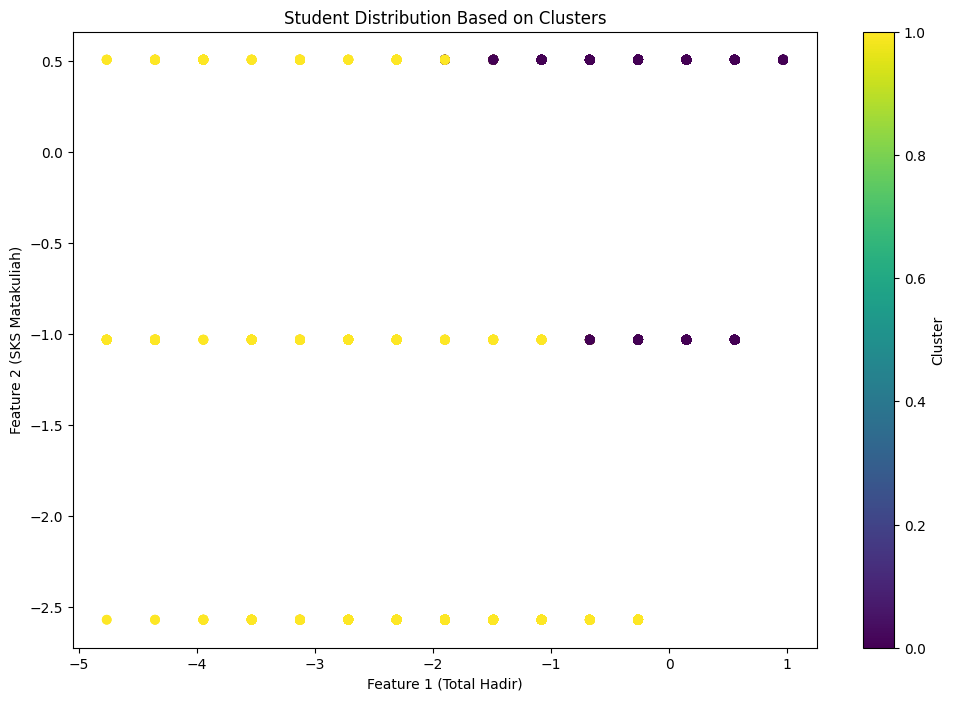

In [14]:
# clustering result plot  
plt.figure(figsize=(12, 8))  
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=kmeans_final.labels_, cmap='viridis')  
plt.title('Student Distribution Based on Clusters')  
plt.xlabel('Feature 1 (Total Hadir)')  
plt.ylabel('Feature 2 (SKS Matakuliah)')  
plt.colorbar(label='Cluster')  
plt.show()

# Use the Model

In [26]:
# load the model
kmeans_model = load('course-preference/course-preference-model-fixed.joblib')  

def get_favorite_courses(npm, merged_data):  
    # get the student data using npm
    student_data = merged_data[merged_data['npm_mahasiswa'] == npm]  
    
    if student_data.empty:  
        return f"Data for NPM {npm} not found."  
    
    # take the appropriate features to make predictions
    features = student_data[['total_hadir', 'sks_matakuliah', 'kode_nilai_numerik', 'kategori_matakuliah_encoded']]  
    features_scaled = scaler.transform(features)

    # predict the cluster 
    cluster = kmeans_model.predict(features_scaled)  

    # make sure the 'cluster' column is present in merged_data 
    favorite_courses = merged_data[(merged_data['cluster'] == cluster[0]) & (merged_data['npm_mahasiswa'] == npm)]

    result = favorite_courses[['nama_mahasiswa', 'kode_matkul', 'kategori_matakuliah']].drop_duplicates(subset=['kategori_matakuliah'])  

    return result


In [28]:
npm_mahasiswa = 2231001

favorite_course = get_favorite_courses(npm_mahasiswa, merged_data)
print(favorite_course)

      nama_mahasiswa kode_matkul kategori_matakuliah
18683          Steby     SI00192              Bahasa
18684          Steby     SI00153   Computer Hardware
18685          Steby     SI00151           Manajemen
18686          Steby     SI00152   Basic Programming
18687          Steby     SI00220          Multimedia
18688          Steby     SI00214              Design
18689          Steby     SI00194               Agama
22528          Steby     SI00157           Animation
22529          Steby     SI00219          Basis Data
22530          Steby     SI00217      Website Making
22531          Steby     SI00224            Hardware
23973          Steby     SI00265    Logical Thinking
23974          Steby     SI00262              Ethics
26045          Steby     SI00261          Manajemen 
26046          Steby     SI00282             Startup
28406          Steby     SI00234    Machine Learning
28407          Steby     SI00268         Tugas AKhir
28410          Steby     SI00208           Mar